# **Enhance LLMs using RAG and Hugging Face**


你被聘來協助人資部門打造一個智慧的公司政策問答系統，員工可以輸入像「我們的休假政策是什麼？」或「我要怎麼申請報銷？」等問題，系統即時回傳清楚答案。這樣的工具透過自動擷取相關內容，省去翻找冗長文件的時間，讓複雜政策更易理解。

本實作聚焦於 Retriever-Augmented Generation (RAG)：結合「檢索」與「生成」的前沿 NLP 方法。流程是先從大資料集中用檢索器（例如 Dense Passage Retriever, DPR）找出與問題相關的資訊段落，再用序列到序列生成模型（例如 GPT-2）根據這些上下文生成精確回答。透過實作練習，你將建立完整的 NLP 管線：從檢索、融合上下文（augmented query）、到生成答案，並學習如何調校模型以提升回應的準確性與相關性，進而應對真實世界的問答挑戰。

## __Table of contents__

<ol>
  <li><a href="#Objectives">Objectives</a></li>
  <li>
    <a href="#Setup">Setup</a>
    <ol>
      <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
      <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
      <li><a href="#Defining-helper-functions">Defining helper functions</a></li>
    </ol>
  </li>
  <li>
    <a href="#Load-and-preprocess-data">Load and preprocess data</a>
    <ol>
      <li><a href="#Downloading-the-text-file">Downloading the text file</a></li>
      <li><a href="#Reading-and-preprocessing-the-data">Reading and preprocessing the data</a></li>
    </ol>
  </li>
  <li>
    <a href="#Building-the-retriever:-Encoding-and-indexing">Building the retriever: Encoding and indexing</a>
    <ol>
      <li><a href="#Encoding-texts-into-embeddings">Encoding texts into embeddings</a></li>
      <li>
        <a href="#Creating-and-populating-the-FAISS-index">Creating and populating the FAISS index</a>
        <ol>
          <li><a href="#Overview-of-FAISS">Overview of FAISS</a></li>
          <li><a href="#Using-IndexFlatL2">Using IndexFlatL2</a></li>
        </ol>
      </li>
    </ol>
  </li>
  <li>
    <a href="#DPR-question-encoder-and-tokenizer">DPR question encoder and tokenizer</a>
    <ol>
      <li><a href="#Distinguishing-DPR-question-and-context-components">Distinguishing DPR question and context components</a></li>
    </ol>
  </li>
  <li>
    <a href="#Example-query-and-context-retrieval">Example query and context retrieval</a>
  </li>
  <li>
    <a href="#Enhancing-response-generation-with-large-language-models-(LLM)">Enhancing response generation with LLMs</a>
    <ol>
      <li><a href="#Loading-models-and-tokenizers">Loading models and tokenizers</a></li>
      <li><a href="#GPT2-model-and-tokenizer">GPT2 model and tokenizer</a></li>
      <li><a href="#Comparing-answer-generation:-With-and-without-DPR-contexts">Comparing answer generation: With and without DPR contexts</a>
        <ol>
          <li><a href="#Generating-answers-directly-from-questions">Generating answers directly from questions</a></li>
          <li><a href="#Generating-answers-with-DPR-contexts">Generating answers with DPR contexts</a></li>
        </ol>
      </li>
    </ol>
  </li>
  <li><a href="#Observations-and-results">Observations and results</a></li>
  <li><a href="#Exercise:-Tuning-generation-parameters-in-GPT2">Exercise: Tuning generation parameters in GPT2</a></li>
</ol>


## 目標

完成這個實作後，你將能夠：

- **理解概念與組成**：掌握 Retriever-Augmented Generation（RAG）的基礎，理解在自然語言處理（NLP）中檢索與生成技術如何結合。

- **實作 Dense Passage Retriever（DPR）**：學會設定與使用 DPR，從大型資料集中高效檢索文件，為生成模型提供相關資訊。

- **整合序列到序列模型**：探索如何整合像 GPT-2 這類的序列到序列模型，根據 DPR 提供的上下文生成答案，提高回應的準確性與相關性。

- **建立問答系統**：透過實作建立一個同時使用 DPR 與 GPT-2 的問答系統，模擬實際應用場景。

- **微調與優化 NLP 模型**：習得微調與優化 NLP 模型的技巧，使其在特定任務或資料集上具備更佳表現與適配性。

- **使用專業 NLP 工具**：熟悉使用進階的 NLP 工具與函式庫，例如 Hugging Face 的 transformers 與 dataset 套件，來實作複雜的 NLP 解決方案。

**筆記**

簡單區分：

* DPR（Dense Passage Retriever） 是一種 檢索模型，它把問題和每個候選段落各自編碼成 dense embedding（用兩個 encoder，其實是 bi-encoder 架構），訓練時透過對比學習讓相關的 question-passage pair 在向量空間靠得近，不相關的拉開。它的工作是「把文字（問題/段落）轉成向量」，讓語意可以用距離比對。

* Faiss 是一個 向量檢索/索引庫，由 Facebook AI Research 開發，用來在大量高維向量裡做高效最近鄰搜尋（例如用 L2、cosine 等距離度量找出最接近的那些 embeddings）。它不會自己產生 embedding，只負責「給定一堆向量後快找出跟 query 向量最接近的」。

典型 RAG pipeline 中兩者搭配：

1. 用 DPR 把所有段落和問題都編成向量（passage embeddings + question embedding）。

2. 把 passage embeddings 存進 Faiss 建索引。

3. 用 Faiss 用 question embedding 去查找 top-k 最相關的段落（nearest neighbors）。

4. 把取回的段落拼成 augmented prompt 丟給生成模型（如 BART/GPT2）產生回答。

所以：

* DPR = embedding/語意表示的產生者

* Faiss = 在這些 embedding 裡做快速相似度檢索的工具

兩者不是同類，但常一起用來做語意檢索 + 增強生成（RAG）。


----


# Setup



在這個實作中，你會使用多個專為自然語言處理、資料操作與高效計算設計的函式庫：

* **[wget](https://pypi.org/project/wget/)**：用來從網路下載檔案，對取得資料集或預訓練模型非常重要。

* **[torch](https://pytorch.org/)**：PyTorch 函式庫，是機器學習與神經網路運算的基礎，提供 GPU 加速與動態網路建構能力。

* **[numpy](https://numpy.org/)**：Python 中做數值運算的核心，負責處理向量、矩陣等資料結構。

* **[faiss](https://github.com/facebookresearch/faiss)**：專門用於高效密集向量的相似度搜尋與分群，對資訊檢索任務至關重要。

* **[transformers](https://huggingface.co/transformers/)**：提供大量預訓練模型以支援各種 NLP 任務，例如：

    * Encoder 向量編碼
 
        * **DPRQuestionEncoder** / **DPRContextEncoder**：分別將問題與上下文編碼成向量嵌入，用於檢索。
    
    * **[tokenizers](https://huggingface.co/docs/tokenizers/)**：將文字輸入轉成模型可處理的數值表示（tokens），確保模型能有效理解與處理文字，例如：
    
        * **[DPRQuestionEncoderTokenizer](https://huggingface.co/transformers/model_doc/dpr.html)** / **[DPRContextEncoderTokenizer](https://huggingface.co/transformers/model_doc/dpr.html)**：把文字轉成各自模型需要的格式，以達到最佳處理與效能。


## Installing required libraries


Before starting with the lab exercises, it's crucial to set up your working environment with the necessary libraries. This setup ensures that all the tools and libraries needed for implementing and running the RAG-based solutions are available.
The following required libraries are __not__ preinstalled in the Skills Network Labs environment. __You will need to run the following cell__ to install them.

***Note : After installing please ensure that you restart the kernel and execute the subsequent cells.***


In [1]:
%pip install --user transformers datasets torch faiss-cpu wget


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --user matplotlib scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Importing required libraries
It is recommended that you import all required libraries in one place (here):_


In [3]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch

import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Defining helper functions


In [4]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)
    
    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))
    
    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])
    
    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

**筆記**

這段函式是在把高維資料降到三維用 t-SNE 視覺化並畫成 3D 散點圖，逐步目的如下：
1. 降維（TSNE）:
   用 t-SNE 把輸入的高維 `data` 投影到 3 個維度（方便用 3D 畫出來）。
   `random_state` 固定結果可重現。
   `perplexity` 設為 `data.shape[0]-1` 意圖是把每個點當成 neighbor，但這個值通常太大（t-SNE 建議是介於 5~50，且小於樣本數的一部分），可能導致效果怪異或收斂問題。
3. 設置 3D 畫布
4. 配色
5. 畫散點
6. 加軸標籤與標題、圖例

# Load and preprocess data

This part of the lab focuses on loading and preparing the text data for the question-answering system. You will start by downloading a specific text file and then reading and preprocessing it to make it suitable for NLP tasks.

## Downloading the text file

The `wget` library is used to download the text file containing the data. This file, named `companyPolicies.txt`, contains various company policies formatted in plain text. Here is how you download it:


In [ ]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

# Use wget to download the file
wget.download(url, out=filename)
print('file downloaded')

file downloaded


## Reading and preprocessing the data
Once the file is downloaded, the next step is to read and preprocess the text. This involves opening the file, reading its contents, and splitting the text into individual paragraphs. Each paragraph represents a section of the company policies. You can also filter out any empty paragraphs to clean your dataset:


**My Notes**
> 這段程式從 companyPolicies.txt 讀取全文、以換行切成段落、去除前後空白與空段落，回傳乾淨的段落列表並取前十個顯示。

In [5]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    # Split the text into paragraphs (simple split by newline characters)
    paragraphs = text.split('\n')
    # Filter out any empty paragraphs or undesired entries
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:10]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

Lets look at the first few samples from the file:


for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )

You are encouraged to substitute `companyPolicies.txt` with any other text file or set of files relevant to your interests or projects. This allows for experimentation with different types of content and formats, enhancing your learning experience and adaptability of the skills taught in this lab.


# 建立檢索器：編碼與建立索引
編碼文件是將文字轉成電腦能處理的數值資料。這個流程從清理文字開始，然後用專門工具把詞彙轉換成數值表示（向量）。這些向量讓系統能根據使用者查詢更容易地搜尋並擷取相關文件。

在本節中，你會準備文字資料供高效檢索使用：將段落編碼成向量嵌入(vector embeddings)（也就是上下文嵌入, context embeddings），接著用 FAISS 對這些嵌入建立索引。這樣你的問答系統在處理問題時，就能快速找到最相關的資訊。

## 將文字編碼成嵌入向量

我們將使用 Dense Passage Retriever（DPR）模型，特別是其上下文編碼器（context encoder），把預處理過的文字資料轉成密集向量嵌入（embeddings）。這些嵌入捕捉文字的語意，使得基於相似度的檢索變得有效。像 DPRContextEncoder 與 DPRContextEncoderTokenizer 這類 DPR 模型建立在 BERT 架構之上，但專注於密集段落檢索；它們與一般用途的 BERT 不同，訓練目標是對比學習（contrastive learning）以找出相關段落，而 BERT 則是處理各種通用的 NLP 任務。

Let's break down each step:



**1. Tokenization**: Each text is tokenized to format it in a way that is compatible with the encoder. This involves converting text into a sequence of tokens with attention masks, ensuring uniform length through padding and managing text size through truncation.


```DPRContextEncoderTokenizer``` object is identical to ```BertTokenizer``` and runs end-to-end tokenization including punctuation splitting and wordpiece. Consider the following sample:


In [6]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


Please ignore the warnings above as they will be handled automatically.

Let's use this sample as it is simpler to relate the output back to BERT.


In [7]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


You can view the token indexes. Let's apply it to the text.


In [8]:
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

- `token_type_ids`: These are segment embeddings used to distinguish different sentences or segments within the input. This is particularly useful in tasks that involve multiple types of input, such as question answering, where questions and context may need to be differentiated.（中文：這些是用來區分輸入中不同句子或片段的 segment embedding。在涉及多種類型輸入的任務（例如問答系統）中特別有用，因為問題與上下文需要被區別開來。）

- `attention_mask`: The attention mask indicates which tokens should be attended to by the model. It has a value of 1 for actual tokens in the input sentences and 0 for padding tokens, ensuring that the model focuses only on meaningful data.（中文：注意力遮罩表示模型應該關注哪些 token。對輸入中的實際 token 值為 1，對 padding token 值為 0，確保模型只聚焦在有意義的內容上。）

-  `input_ids`: These represent the indices of tokens in the tokenizer's vocabulary. To translate these indices back into readable tokens, you can use the method `convert_ids_to_tokens` provided by the tokenizer. Here's an example of how to use this method:（中文：這些代表 tokenizer 詞彙表中 token 的索引。要把這些索引還原成可讀的 token，可以使用 tokenizer 提供的 convert_ids_to_tokens 方法。以下是一個使用此方法的範例：）


In [9]:
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


**筆記**
1. input_ids
* 意思：把原始文字切成詞元（tokens）後，對應到模型詞表（vocabulary）中的整數 ID。包括必要的 special tokens（如 [CLS], [SEP], 或起始/結束符號）與 padding。
* 用途：模型的實際輸入，用來查 embedding 矩陣得到 token 向量。
* 範例： 
文本 "Hello world" 可能被 tokenized 成 ["Hello", "world"]，再映射成 input_ids = [15496, 2159]（數字依詞表不同）。若是固定長度 5 且要 padding 會是 [101, 15496, 2159, 102, 0] 之類（假設 101/102 是 special token）。

2. token_type_ids（又稱 segment IDs）
* 意思：標記每個 token 屬於哪個 segment／句子，常見於處理句對（sentence pair）任務，例如 question + context、下一句預測等。
* 用途：讓模型知道哪些 tokens 是第一段、哪些是第二段，區分結構。
* 值域：通常是 0 或 1（第一句為 0，第二句為 1）。
* 範例： 
問題+上下文：[CLS] What is AI? [SEP] It is artificial intelligence. [SEP] 
則 token_type_ids = [0, 0, 0, 0, 1, 1, 1, 1]。 
（如果只有一段，全部是 0。）

3. attention_mask
* 意思：一個和 input_ids 同長的 binary mask，標示哪些 token 是「實際有效」的（1），哪些是 padding（0）。
* 用途：避免模型在 self-attention 時把注意力分配到 padding 上（padding 不應該帶資訊）。
* 範例： 
input_ids = [101, 15496, 2159, 102, 0]（最後一個是 padding） 
attention_mask = [1, 1, 1, 1, 0]

額外常見（視 tokenizer/設定而有）：
* overflowing_tokens：當輸入太長被截斷時，多出來被丟掉的 token（通常在做 sliding window 時使用）。
* num_truncated_tokens：被截掉的 token 數量。
* position_ids：明示的位置編號（大部分模型自動推算，不一定出現在 tokenizer output）。

結合起來的典型流程（面試可以簡述）：
文字 → tokenizer 產生 input_ids, token_type_ids, attention_mask → 送進 encoder → 得到 embedding（例如取 pooler output 或 sequence output） → 用於相似度比對 / downstream task

**🌟小結要點**
* input_ids 是字串轉成的數字 token。
* token_type_ids 區分句子片段（有沒有兩段輸入）。
* attention_mask 告訴模型哪裡是有效內容、哪裡是填充不用看。


**sepcial tokens**

[CLS] 和 [SEP] 都是典型的 special tokens（特殊詞元），在 BERT 及其衍生架構（像 DPR）中有固定語意/用途：

* [CLS]（classification token）：放在整個輸入最前面，模型會把這個位置的 hidden state（通常透過 pooler output）當作整段輸入的摘要向量，用於表示整個 sequence 的語意（例如做檢索、分類、對比學習等）。
例：[CLS] question [SEP] context [SEP] 裡的 [CLS] 聚合了後面所有內容。

* [SEP]（separator token）：用來分隔不同 segment（例如 question 跟 context），也用來標示 sequence 的結尾。在句對或多段輸入時常出現多個 [SEP]。
例：[CLS] What is policy? [SEP] The policy says... [SEP]

這些 special tokens 跟 token_type_ids 搭配可以讓模型知道哪些 token 屬於哪一段（例如第一段是 question、第二段是 context），attention_mask 則控制哪些位置是實際有效內容。

其他常見 special tokens 還包括：

* [PAD]：填充用，不加入語意（會被 attention mask 忽略）

* [MASK]：BERT 預訓練時用來做遮罩語言模型的替代 token

* [CLS] / [SEP] 在 GPT/BART 類 autoregressive 模型裡通常不用，有些改用 BOS/EOS 或只是靠位置與結構處理段落。

**2. 編碼**：將分詞後的文字送入 `context_encoder`。該模型處理輸入並為每一筆產生一個 pooled output，將整段文字的資訊壓縮成單一的密集向量嵌入，代表該文本的語意精髓。

DPR 模型（包括 ```DPRContextEncoder```）建立在 BERT 架構之上，但專注於密集段落檢索。它們與一般用途的 BERT 不同，DPR 的訓練集中在對比學習（contrastive learning）以找出相關段落，而 BERT 則是處理各種通用的 NLP 任務。


In [10]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

請忽略上方的警告，系統會自動處理它們。

`context_tokenizer` 和 `context_encoder` 配合使用來處理文字資料，將段落轉成適合後續 NLP 任務的上下文嵌入。以下是這些元件如何應用在前 20 個段落上的說明：

- `context_tokenizer` 會接收前 20 個段落，並將每一個轉換成 token ID 序列，格式化為可輸入 PyTorch 模型的形式。這個過程包含：

    - **補齊（Padding）**：為了統一長度，較短的文字序列用 0 補齊到指定的最大長度 256 個 token。

    - **截斷（Truncation）**：過長的文字會在 256 個 token 處被截掉，以維持所有輸入的一致性。

- 分詞後的資料再送進 `context_encoder`，該編碼器處理這些 token 序列並產生上下文嵌入。編碼器輸出的每一個 embedding 向量都代表其對應段落的語意內容，封裝了該段落的關鍵資訊與語境細節。

- 編碼器的輸出是一個 PyTorch 張量（tensor），每一列對應一個不同段落的 embedding。這個張量的形狀由處理的段落數與 embedding 維度決定，反映出每個段落內容的細緻、上下文化表示。


In [11]:
#shuffling samples so that the samples are not ordered based on the category they belong to
random.shuffle(paragraphs)

In [12]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256) 
tokens
outputs=context_encoder(**tokens)
# pooler_output 是把整個輸入「壓縮」成一個 fixed-size 向量（通常是基於第一個 token 或經過一層變換後的聚合表示），代表整個段落的語意摘要
outputs.pooler_output

tensor([[ 7.5076e-01,  5.6438e-01, -3.8410e-02,  ..., -5.8728e-01,
         -2.7589e-01,  2.3054e-02],
        [ 2.9181e-01,  3.4065e-01,  4.2136e-02,  ..., -4.3425e-01,
         -5.1575e-01,  1.1386e-01],
        [ 8.4058e-01,  6.8967e-01,  2.0175e-02,  ..., -4.0660e-01,
          5.1068e-02,  3.4253e-01],
        ...,
        [ 7.3348e-01,  5.7937e-01,  3.8566e-01,  ..., -3.4257e-01,
         -4.6565e-01, -3.5042e-02],
        [ 3.9729e-01,  4.5317e-01,  3.8871e-01,  ..., -4.5585e-01,
         -3.1792e-01, -1.9409e-04],
        [ 3.8004e-01,  1.3349e-01, -1.4076e-01,  ..., -2.7981e-01,
         -1.7635e-01,  3.3845e-01]], grad_fn=<SliceBackward0>)

t-SNE（t 分佈隨機鄰居嵌入）是一種有效的高維資料視覺化方法，對分析來自 ```DPRContextEncoder``` 模型的輸出特別有用。```DPRContextEncoder``` 將段落編碼為密集向量，這些向量在高維空間中捕捉了段落的語意。將 t-SNE 應用於這些密集向量，可以將它們的維度降到二或三維，產生一個保留段落間關係的視覺化表示。這讓你能探索相似段落的群聚、辨識在高維空間中原本難以察覺的模式。最終的圖能提供模型如何區分不同段落類型的洞察，並揭示編碼資料內在的結構。

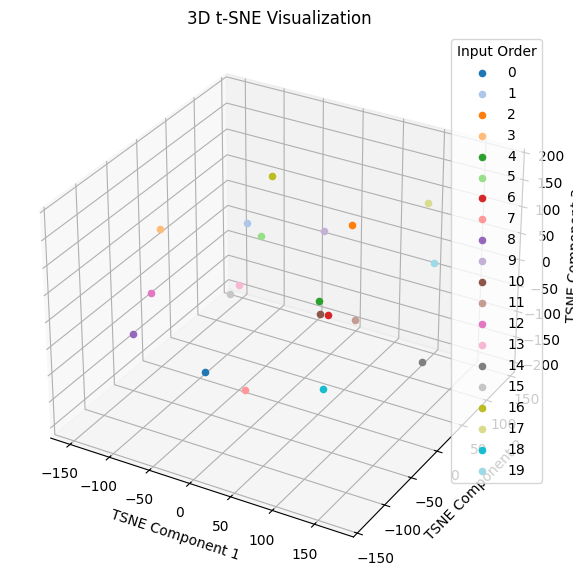

In [13]:
tsne_plot(outputs.pooler_output.detach().numpy())

Samples 16 and 12 are closer to each other on the graph shown above. Let's view the corresponding paragraphs:


In [14]:
print("sample 16:", paragraphs[16])

sample 16: Environmental Responsibility: We are committed to minimizing our environmental footprint and promoting sustainable practices.


In [15]:
print("sample 12:", paragraphs[12])

sample 12: Harassment: Harassment in any form, whether based on the aforementioned characteristics or any other protected status, is unacceptable. This encompasses unwelcome advances, offensive jokes, slurs, and other verbal or physical conduct that creates a hostile or intimidating work environment.


Both samples discuss diversity. Rather than relying solely on visual inspection, distances between embeddings are employed to determine the relevance of retrieved documents or passages. This involves comparing the query’s embedding with the embeddings of candidate documents, enabling a precise and objective measure of relevance.


**3. 聚合**：所有從文本產生的個別嵌入會被聚合成一個單一的 NumPy 陣列。這個聚合對後續處理步驟（例如建立索引以加速相似度搜尋）是必要的。

這種方法有效地將段落轉成一種壓縮的向量形式，保留了重要的語意資訊，非常適合本實作中所需的檢索任務。接下來，將每個樣本整理成一個清單，每個樣本都有其特定的維度。

In [16]:
embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [17]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

**筆記**

768 是模型架構設定好的「隱藏向量維度」（hidden size），也就是 DPRContextEncoder 底層用的 BERT-based 模型在設計時把每個 token/整段的表示壓縮到 768 維。
換句話說，pooler_output 的 shape 是 (1, 768)，那個 768 就是該預訓練模型的 embedding dimensionality（語意表示的長度）。
如果換用不同變體（像 BERT-large、其他 backbone），這個維度可能是 1024 或其他值，取決於該模型的 config 設計，是在訓練前就固定好的超參數。

Now, let's consolidate all the steps into a function:


In [18]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

## 建立並填入 FAISS 索引

在文字段落被編碼成密集向量嵌入之後，下一個關鍵步驟是建立並填入 FAISS 索引。Facebook AI Similarity Search（FAISS）是由 Facebook 開發的高效函式庫，用於密集向量的相似度搜尋與分群。

#### FAISS 概覽
- **效率**：FAISS 為快速相似度搜尋而設計，在處理大型資料集時特別有價值。它非常適合自然語言處理中需要高效檢索的任務。

- **可擴展性**：它能有效處理大量資料，即使資料集規模擴大也能維持良好效能。

#### 使用 IndexFlatL2
- **索引類型**：IndexFlatL2 是 FAISS 中最簡單也最常用的索引之一。它透過計算查詢向量與資料集中向量之間的歐氏距離（L2 範數）來衡量相似度。這種方法直觀明確，對於需要精確距離計算的應用非常有效。

- **應用情境**：這類索引特別適合在檢索系統中使用，用來找出與查詢向量最接近、最相關的文件或資訊。

In [19]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index

# DPR 問題編碼器與分詞器
Dense Passage Retriever（DPR）在有效檢索與某個問題相關的文件或段落上扮演關鍵角色。以下載入用於編碼問題的 `DPRQuestionEncoder` 與 `DPRQuestionEncoderTokenizer`：

- **問題編碼器（Question encoder）**：DPR 的問題編碼器用來將問題轉換成密集向量嵌入（dense embeddings）。這個步驟強化系統從大量語料中高效比對與檢索相關內容的能力，是精準回答查詢的核心。

- **分詞器（Tokenizer）**：DPR 問題編碼器的分詞器在準備輸入問題時扮演重要角色，具體包括：

    - **標準化文字**：將原始文字轉成標準化的 token ID 序列。

    - **處理輸入**：這些 token ID 被輸入問題編碼器，產出能有效表徵問題語意意圖的嵌入向量。
 

## 區分 DPR 的問題與上下文部分
雖然 DPR 的 question encoder 與 context encoder 都是檢索框架的核心，但它們在流程中負責不同角色並各自最佳化：

- **DPR question encoder 與其 tokenizer**：專門用來處理與編碼查詢（問題）。問題編碼器將問題轉成密集向量，用來在語料庫中搜尋最相關的文件；對應的分詞器負責把問題格式化成編碼器可以正確處理的形式。

- **DPR context encoder 與其 tokenizer**：相對地，這部分專注於編碼潛在的答案段落或文件。上下文編碼器從大量文字建立嵌入，系統再將這些與問題嵌入比較以找出最佳匹配。

In [20]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Please ignore the warnings above as they will be handled automatically.


# 範例查詢與上下文檢索
在本實作的這一部分，你將示範如何用系統處理一個具體查詢，並從已建立索引的資料中檢索出最相關的上下文。這個範例有助於說明系統各個元件如何互動，完成一次完整的檢索任務。

首先，對一個範例查詢進行處理：將原始文字問題轉換為 DPR 問題編碼器能理解的格式，然後編碼成密集向量（query embedding）。接著使用這個編碼後的問題，在已建好的 FAISS 索引中搜尋最相關的上下文。這一步展示了 FAISS 索引在根據查詢相似度檢索資訊時的實際應用。

在根據問題嵌入搜尋出相關上下文後，輸出包含兩個關鍵部分：

- **D（距離）**：這個陣列包含查詢嵌入與被檢索到的文件嵌入之間的距離。距離衡量查詢與每個文件的相似度，距離越小表示相關性越高。這些數值幫助判斷每個被取回的上下文與查詢的貼近程度。

- **I（索引）**：這個陣列存放在 paragraphs 列表中被識別為與查詢最相關的段落的位置索引。這些索引對應原始資料中段落的位置，便於取出實際文字內容。

`D` 與 `I` 的組合同時提供了量化的相關性度量與具體最相關的內容，使得系統能針對使用者查詢給出完整、有依據的回應。

In [21]:
# Example question
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
D, I = index.search(question_embedding, k=5)  # Retrieve top 5 relevant contexts
print("D:",D)
print("I:",I)

D: [[72.76534  74.71623  84.38811  88.364365 90.28712 ]]
I: [[35 51 50 11 62]]


You can print out Top 5 relevant contexts and their distance:


In [22]:
print("Top 5 relevant contexts:")
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")

Top 5 relevant contexts:
1: 6.	Drug and Alcohol Policy
distance 72.76534271240234

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71623229980469

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38810729980469

4: 9.	Discipline and Termination Policy
distance 88.36436462402344

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.28711700439453



Let's convert the above to a function:


In [23]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

# 提升回應生成：結合大型語言模型（LLMs）
在檢索元件選出相關文件或段落之後，大型語言模型（LLM）會將這些資訊與其預訓練得到的廣泛知識整合，構建連貫且符合上下文的答案。這個過程利用 LLM 理解並操作語言的能力，根據檢索階段提供的特定輸入，生成對複雜問題的精確回應。

### 載入模型與分詞器
在使用詞嵌入(word embeddings)之前，必須先載入一個 LLM 來生成文字。此時該 LLM 對你的資料集或任務還沒有專門的知識，但它具備一般性知識。

在本實作中，你將載入生成答案與編碼問題所需的核心模型與對應的分詞器。這些組件來自 Hugging Face Transformers 函式庫，其以豐富的預訓練模型集合聞名。

### GPT2 模型與分詞器
GPT2（Generative Pretrained Transformer 2）是一個強大的序列到序列模型，以其在文字生成任務中的表現著稱：

- **模型（Model）**：GPT2 被配置用於條件式文本生成，擅長根據檢索系統提供的上下文生成答案。它的架構支持複雜且依賴語境的文本生成任務，非常適合問答系統中需要細緻、具語意層次的回應。

- **分詞器（Tokenizer）**：GPT2 的對應分詞器在預處理文字輸入上扮演關鍵角色，包含：

    - **分詞（Tokenization）**：把文字拆解成模型可以處理的 token。

    - **轉成 token ID**：將 token 轉為模型能理解的數值識別碼。

    - **補齊與截斷（Padding and truncation）**：確保所有輸入序列為統一長度，短的補齊、長的截斷到指定最大長度。

透過整合這些模型與分詞器，系統具備處理問答所需的兩大核心任務：

- **編碼使用者查詢**：使用 DPR 問題編碼器及其分詞器，將使用者問題轉成能有效檢索相關資訊的形式。

- **生成相關答案**：GPT2 模型接收檢索回來的資訊，生成不僅相關而且具有上下文豐富性的回應。

將 GPT2 用於生成、DPR 用於問題編碼，構建出一個強健的自然語言處理解決方案，使系統能夠對使用者詢問提供準確且考量語境的回答。

In [24]:
# 從 Hugging Face 下載並載入對應的 GPT-2 分詞器（tokenizer），它負責把文字轉成模型能處理的 token ID，以及把 token ID 轉回文字。
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

# 載入預訓練好的 GPT-2 因果語言模型（Causal Language Model），用於基於前文逐步生成文字（例如回答問題）。
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

# 設定生成時使用的 padding token ID。GPT-2 預設沒有明確的 pad token，這一行把 tokenizer 定義的 pad_token_id 指定給模型的 generation 設定，
# 避免在呼叫 generate 時出現警告或處理 batch padding 時出錯，確保模型知道哪些 token 是填充、不應當被解碼或影響生成邏輯。
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Input text: 


In [25]:
contexts= "What is a large language model?"

Tokenize the input text to prepare it for the model:


In [26]:
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


Utilize the LLM to generate text, ensuring that the output is in token indexes:


In [27]:
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

Please ignore the warnings above as they will be handled automatically.

Decode the generated token indexes back to text:


In [28]:
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


## 比較答案生成：有無 DPR 上下文

在本實作的這一部分，你將探索從 DPR 檢索出的上下文如何影響 GPT2 模型生成答案的品質。這個比較將說明上下文資訊對回答準確性與相關性的影響。```generate_answer``` 函式本質上幾乎相同；差別在於它會將從查詢與上下文檢索得到的內容串接（join）進去作為輸入。

### Generating answers directly from questions

First, let's look at how the GPT2 model generates answers without any additional context:


In [29]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)
    
    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    
    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [30]:
# Example usage
question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


### Generating answers with DPR contexts
Next, let's demonstrate how answers are generated when the model utilizes contexts retrieved via DPR, which are expected to enhance the answer's relevance and depth:


In [31]:
def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [32]:
question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

paragraphs indexs [[64 40 62 24  3]]


The top paragraphs from the query and context retrieval are show here:


In [33]:
top_contexts = [paragraphs[idx] for idx in I[0]] 
print(f"top_contexts {top_contexts}")

top_contexts ['4.\tMobile Phone Policy', 'The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance.', 'Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.']


You can input the response from the model.


In [34]:
# Assume `I[0]` contains indices of top contexts from the retrieval step
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

Generated Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the sta

## 觀察與結果
在比較直接用 GPT2 生成答案與加入 DPR 上下文後的生成結果後，可以看到在品質與相關性上的明顯差異：

- **直接生成**：
不使用 DPR 上下文時，GPT2 完全依賴其預訓練知識來推測答案。這樣的做法有時會導致回答不夠精準、過於泛泛，因為模型缺乏與查詢直接相關的具體資訊。

- **加上 DPR 上下文的生成**：
結合 DPR 後，GPT2 可以取得與查詢相關的具體內容，大幅提升生成答案的準確性與細節，回應更具資訊性且符合語境。

這個比較清楚顯示出將 DPR 檢索與像 GPT2 這類生成模型整合，能得到更有效且具上下文相關性的答案，證明在自然語言處理應用中結合「檢索」與「生成」技術、利用 DPR 提供的上下文能顯著提升生成內容的品質。

# 練習：調整 GPT2 的生成參數
## 目標
探索在以上下文為基礎的問答系統中，調整 GPT2 的生成參數如何影響回應的品質與細節。

## 任務
修改 generate_answer 函式中的參數 `max_length`、`min_length`、`length_penalty` 和 `num_beams`，觀察它們如何影響 GPT2 根據給定上下文生成的答案。

## 說明

### 設定
使用現有流程：先檢索出與查詢相關的上下文，再把這些上下文傳給 GPT2 生成答案。

### 參數調整
嘗試不同的 `max_length`、`min_length`、`length_penalty` 和 `num_beams` 組合。
至少用三組不同的參數設定來生成答案。

### 分析
比較各組生成的答案，評估參數變動如何影響回應的簡潔度、相關性與整體品質。

In [35]:
## Write your code here
def generate_answer(contexts, max_len=50, min_len=40, length_penalty=2.0, num_beams=4):
    # Concatenate the retrieved contexts to form the input to BAR
    input_text = ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(
        inputs['input_ids'],
        max_new_tokens=max_len,
        min_length=min_len,
        length_penalty=length_penalty,
        num_beams=num_beams,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Define the question
question = "what is mobile policy?"

# Retrieve relevant contexts
_, I = search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
top_contexts = [paragraphs[idx] for idx in I[0]] 

# Test different generation settings
settings = [
    (50, 50, 1.0, 2),
    (120, 30, 2.0, 4),
    (100, 20, 2.5, 6)
]

# Generate and print answers for each setting
for setting in settings:
    answer = generate_answer(top_contexts, *setting)
    print(f"Settings: max_new_tokens={setting[0]}, min_length={setting[1]}, length_penalty={setting[2]}, num_beams={setting[3]}")
    print("Generated Answer:", answer)
    print("\n" + "="*80 + "\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=50, min_length=50, length_penalty=1.0, num_beams=2
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=120, min_length=30, length_penalty=2.0, num_beams=4
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best 